In [84]:
import torch
import torch.nn.utils.prune as prune
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import time
import psutil
import os
import copy
import torch.nn as nn
from torchvision.models.resnet import BasicBlock
from torch.ao.quantization.fake_quantize import FakeQuantize
from torch import Tensor
from typing import Any, Callable, List, Optional, Type, Union

# 1. Load pretrained ResNet-18
model = models.resnet18(pretrained=True)
model.eval()

# 4. Prepare a dummy input
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

img = Image.open("/Users/jjvyas1/Downloads/mla_project/n01443537_goldfish.JPEG").convert("RGB")  # replace with a real image path
input_tensor = transform(img).unsqueeze(0)  # batch dimension

In [85]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [86]:
def evaluate(model, device_str='cuda'):
    global input_tensor

    if device_str not in ['cpu', 'cuda']:
        raise NotImplementedError("`device_str` should be 'cpu' or 'cuda'")
    if device_str == 'cuda':
        assert torch.cuda.is_available(), 'CUDA is not available'

    # Prepare input
    input_batch = input_tensor.unsqueeze(0)[0]

    # Match input dtype to model
    model_dtype = next(model.parameters()).dtype
    input_batch = input_batch.to(dtype=model_dtype)

    # Move model to device + dtype
    model = model.to(device_str)
    if model_dtype == torch.float16:
        model = model.half()

    model.eval()
    with torch.no_grad():
        output = model(input_batch)

        # Dequantize if needed
        if output.is_quantized:
            output = output.dequantize()

        probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Load ImageNet labels
    with open("/Users/jjvyas1/Downloads/mla_project/imagenet_classes.txt", "r") as f:
        categories = [s.strip() for s in f.readlines()]

    # Print Top-5 predictions
    top5_prob, top5_catid = torch.topk(probabilities, 5)
    for i in range(top5_prob.size(0)):
        print(f"{categories[top5_catid[i]]}: {top5_prob[i].item():.4f}")


In [87]:
evaluate(model, 'cpu')

goldfish: 0.8218
axolotl: 0.1419
tench: 0.0175
sturgeon: 0.0051
puffer: 0.0048


In [88]:
def get_model_size(model):
    torch.save(model.state_dict(), "temp.p")
    size_mb = os.path.getsize("temp.p") / 1e6
    os.remove("temp.p")
    print(f"Model size: {size_mb:.2f} MB")
    return size_mb


In [89]:
get_model_size(model)

Model size: 46.83 MB


46.828292

In [90]:
def measure_inference_time(model, input_size=(1, 3, 224, 224), device='cpu', repeats=50):
    model.eval()
    dummy_input = torch.randn(input_size).to(device)
    model.to(device)

    for _ in range(10):
        try:
            _ = model(dummy_input)
            start = time.time()
            for _ in range(repeats):
                _ = model(dummy_input)
            end = time.time()

            avg_time = (end - start) / repeats
            print(f"Inference time (avg over {repeats}): {avg_time*1000:.2f} ms")
        except:
            dummy_input = dummy_input.half().to(device)
            start = time.time()
            for _ in range(repeats):
                _ = model(dummy_input)
            end = time.time()

            avg_time = (end - start) / repeats
            print(f"Inference time (avg over {repeats}): {avg_time*1000:.2f} ms")
        return avg_time

In [91]:
measure_inference_time(model)

Inference time (avg over 50): 17.49 ms


0.017487998008728026

In [92]:
import torch
from Downloads.mla_project.resnet import resnet18
# loading the quantized model
model = resnet18(pretrained=True)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (add_relu_FF): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e

In [93]:
model.eval()
converted_model = model.half()
converted_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (add_relu_FF): FloatFunctional(
        (activation_post_process): Identity()
      )
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e

In [94]:
get_model_size(converted_model)

Model size: 23.43 MB


23.431044

As CPU doesn't support for fp16 optimization, this is quite of a time consuming process,
however fp16 quantization proves beneficial for GPU.

In [51]:
measure_inference_time(converted_model)

Inference time (avg over 50): 804.81 ms


0.8048054361343384

In [95]:
evaluate(converted_model, 'cpu')

goldfish: 0.8208
axolotl: 0.1427
tench: 0.0176
sturgeon: 0.0052
puffer: 0.0048


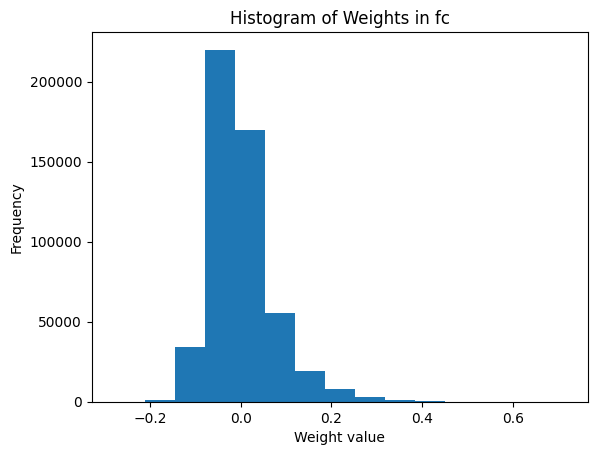

In [96]:
import matplotlib.pyplot as plt

for name, module in converted_model.named_modules():
    if name == "fc":
        weights = module.weight.dequantize().flatten().detach().numpy()
        plt.hist(weights, bins=15)
        plt.title(f"Histogram of Weights in {name}")
        plt.xlabel("Weight value")
        plt.ylabel("Frequency")
        plt.show()

In [97]:

for name, module in converted_model.named_modules():
    print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu1
layer1.0.conv2
layer1.0.bn2
layer1.0.add_relu_FF
layer1.0.add_relu_FF.activation_post_process
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu1
layer1.1.conv2
layer1.1.bn2
layer1.1.add_relu_FF
layer1.1.add_relu_FF.activation_post_process
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu1
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.0.add_relu_FF
layer2.0.add_relu_FF.activation_post_process
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu1
layer2.1.conv2
layer2.1.bn2
layer2.1.add_relu_FF
layer2.1.add_relu_FF.activation_post_process
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu1
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.0.add_relu_FF
layer3.0.add_relu_FF.activation_post_process
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu1
layer3.1.conv2
layer3.1.bn2
layer3.1.add_relu

In [98]:
import torch.nn.utils.prune as prune
import numpy as np

for name, module in converted_model.named_modules():
  if "conv1" in name or "conv2" in name or "fc" in name:
    print(module)
    weight = module.weight

    # Perform pruning: Setting a fraction of weights to zero (e.g., 30%)
    pruning_amount = 0.3
    num_weights = weight.numel()
    num_pruned_weights = int(pruning_amount * num_weights)
    weight = torch.abs(weight)
    flattened_weights = weight.reshape(-1)
    sorted_indices = torch.argsort(flattened_weights)

    # # Prune the smallest weights
    pruned_weights = flattened_weights.clone()
    pruned_weights[sorted_indices[:num_pruned_weights]] = 0

    # # Reshape pruned weights back to the original shape
    pruned_weights = pruned_weights.view_as(weight)

    # print(module.weight())
    # print(module.bias())
    bias = module.bias
    module.weight =  torch.nn.Parameter(pruned_weights)

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), 

In [99]:
get_model_size(converted_model)

Model size: 23.43 MB


23.431044

As you can see, the inferencing of fp16 quantized + pruned model is too slow.

In [57]:
measure_inference_time(converted_model)

Inference time (avg over 50): 838.77 ms


0.8387669563293457

In [100]:
for name, module in converted_model.named_modules():
  print(name)


conv1
bn1
relu
maxpool
layer1
layer1.0
layer1.0.conv1
layer1.0.bn1
layer1.0.relu1
layer1.0.conv2
layer1.0.bn2
layer1.0.add_relu_FF
layer1.0.add_relu_FF.activation_post_process
layer1.1
layer1.1.conv1
layer1.1.bn1
layer1.1.relu1
layer1.1.conv2
layer1.1.bn2
layer1.1.add_relu_FF
layer1.1.add_relu_FF.activation_post_process
layer2
layer2.0
layer2.0.conv1
layer2.0.bn1
layer2.0.relu1
layer2.0.conv2
layer2.0.bn2
layer2.0.downsample
layer2.0.downsample.0
layer2.0.downsample.1
layer2.0.add_relu_FF
layer2.0.add_relu_FF.activation_post_process
layer2.1
layer2.1.conv1
layer2.1.bn1
layer2.1.relu1
layer2.1.conv2
layer2.1.bn2
layer2.1.add_relu_FF
layer2.1.add_relu_FF.activation_post_process
layer3
layer3.0
layer3.0.conv1
layer3.0.bn1
layer3.0.relu1
layer3.0.conv2
layer3.0.bn2
layer3.0.downsample
layer3.0.downsample.0
layer3.0.downsample.1
layer3.0.add_relu_FF
layer3.0.add_relu_FF.activation_post_process
layer3.1
layer3.1.conv1
layer3.1.bn1
layer3.1.relu1
layer3.1.conv2
layer3.1.bn2
layer3.1.add_relu

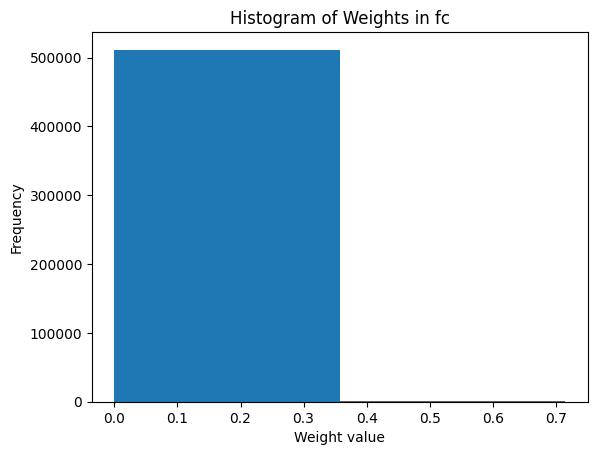

In [101]:
import matplotlib.pyplot as plt

for name, module in converted_model.named_modules():
    if name == "fc":
        weights = module.weight.dequantize().flatten().detach().numpy()
        plt.hist(weights, bins=2)
        plt.title(f"Histogram of Weights in {name}")
        plt.xlabel("Weight value")
        plt.ylabel("Frequency")
        plt.show()
